# MDC 018 - Projeto Final

In [1]:
import pandas as pd

# Carregando os dados de treinamento e teste
train_audience = pd.read_csv("train_audience.csv")

test_audience = pd.read_csv("test_audience.csv")

In [2]:
train_audience

,Show,Rating,Review
0,Game of Thrones,0.5,Lost all guidance without the book. Somehow ru...
1,The Book of Boba Fett,2.5,It felt mostly bizzare. Boba fett himself seem...
2,Safe,3.0,"It started well and got me hooked, but it gets..."
3,Midnight Mass,2.0,Here's what you get in this series: Long-winde...
4,Star Wars: Visions,4.5,"I am a big fan of star wars and anime, so I re..."
...,...,...,...
52411,Ozark,1.0,Don't watch the last season- anticlimactic \nV...
52412,Game of Thrones,1.5,I wanted to give this higher for the excellent...
52413,Attack on Titan,5.0,"This season will make attack on titan, a maste..."
52414,Watchmen,0.5,Looks terrible. Story is about some sort of ra...


In [3]:
train_audience['Rating'] = (train_audience['Rating']*2).astype(int)-1

Verificação de balanceamento:

In [4]:
train_audience['Rating'].value_counts()

Rating
9    23642
0     7016
7     3869
8     3792
1     3309
3     2690
6     2340
5     2141
2     2040
4     1577
Name: count, dtype: int64

Ambos conjuntos estão fortemente desbalanceados.

# Predição de Ratingo

Conjunto train_critic

In [5]:
# Separação entre conjunto de treino e validação
from sklearn.model_selection import train_test_split

# Remove NAs
train_audience.dropna(subset=['Review'], inplace=True)

(train_audience_df, val_audience_df) = train_test_split(train_audience, test_size=0.2)
train_audience_df['Rating'].value_counts()

Rating
9    18948
0     5638
7     3097
8     3047
1     2647
3     2145
6     1844
5     1688
2     1618
4     1260
Name: count, dtype: int64

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular os pesos para as classes
classes = train_audience['Rating'].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(classes),
    y=train_audience['Rating']
)

class_weights = dict(zip(classes, weights))
class_weights

{0: 0.7470923603192703,
 4: 3.3237793278376664,
 5: 2.4482017748715554,
 3: 1.9485501858736058,
 8: 1.3822784810126583,
 9: 0.2217071313763641,
 6: 2.24,
 1: 1.584043517679057,
 7: 1.3547686740759886,
 2: 2.5694117647058823}

In [7]:
val_audience_texts = val_audience_df["Review"].tolist()
val_audience_labels = val_audience_df["Rating"].tolist()

In [8]:
from sklearn.metrics import balanced_accuracy_score
from transformers import pipeline
import matplotlib.pyplot as plt

def get_balanced_accuracy(model, tokenizer, texts, labels):
    # Cria o pipeline com truncamento ativado
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        truncation=True,  # Trunca textos longos automaticamente
        max_length=512    # Garante que o comprimento não exceda o limite do modelo
    )

    predictions = []
    for text in texts:
        result = classifier(text)
        # Extrai o rótulo e converte para inteiro
        label = int(result[0]["label"].split("_")[-1])
        predictions.append(label)

    # Calcula a acurácia balanceada
    return round(float(balanced_accuracy_score(labels, predictions)), 2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(trainer, dataset, label_names=None, cmap="Blues"):
    predictions_output = trainer.predict(dataset)
    logits = predictions_output.predictions
    labels = predictions_output.label_ids
    predictions = logits.argmax(axis=-1)
    cm = confusion_matrix(labels, predictions,  normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=cmap, values_format=".2f")
    plt.show()
    return cm

def mae(y_true, trainer, dataset):
    predictions_output = trainer.predict(dataset)
    logits = predictions_output.predictions
    predictions = logits.argmax(axis=-1)
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

C:\Users\p.moura\.virtualenvs\mdc-projeto-final\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import balanced_accuracy_score


model_name = "prajjwal1/bert-tiny"  # Ou outro checkpoint pré-treinado
num_labels = 10  # Número de classes no seu problema

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(model_name)
# Supondo que 'labels' contenha todos os rótulos do conjunto de treinamento
labels = train_audience['Rating']  # Altere para acessar os rótulos no seu dataset

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)  # Converta para um tensor PyTorch
import torch.nn as nn

#tokeniza os datasets
train_encodings = tokenizer(train_audience_df['Review'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_audience_df['Review']), truncation=True, padding=True, max_length=128)

In [11]:
class CustomTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Define a função de perda com os pesos de classe
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [12]:
import evaluate
from sklearn.metrics import balanced_accuracy_score

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

def compute_metrics_balanced(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calcular acurácia balanceada
    balanced_acc = balanced_accuracy_score(labels, predictions)

    return {"balanced_accuracy": balanced_acc}

In [13]:
training_args = TrainingArguments(
    output_dir="./results_audience_roberta",
    learning_rate=5e-5,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    load_best_model_at_end=True,               # Carregar o melhor modelo ao final
    metric_for_best_model="balanced_accuracy", # Métrica para determinar o melhor modelo
    save_strategy="epoch",                     # Salvar checkpoints no final de cada época
    save_total_limit=1,                        # Limitar os checkpoints a 1 para economizar espaço
    greater_is_better=True                     # Se maior métrica significa melhor modelo
)

train_audience_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(train_audience_df['Rating'])
})

val_audience_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(val_audience_df['Rating'])
})

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_audience_dataset,
    eval_dataset=val_audience_dataset,
    class_weights=class_weights,
    compute_metrics=compute_metrics_balanced
)
trainer.train()

Epoch,Training Loss,Validation Loss,Balanced Accuracy
1,1.905700,1.860514,0.266631
2,1.768300,1.784780,0.281271
3,1.705400,1.805570,0.285973
4,1.632400,1.806555,0.294987
5,1.592100,1.850253,0.293479
6,1.516700,1.858760,0.298610
7,1.531700,1.882145,0.297725
8,1.462800,1.902508,0.294316


TrainOutput(global_step=41936, training_loss=1.6470586142891102, metrics={'train_runtime': 4300.8167, 'train_samples_per_second': 77.998, 'train_steps_per_second': 9.751, 'total_flos': 106813999497216.0, 'train_loss': 1.6470586142891102, 'epoch': 8.0})

In [14]:
get_balanced_accuracy(model, tokenizer, val_audience_texts, val_audience_labels)

0.3

In [15]:
trainer.evaluate()

{'eval_loss': 1.8587595224380493,
 'eval_balanced_accuracy': 0.2986101012542183,
 'eval_runtime': 23.6838,
 'eval_samples_per_second': 442.665,
 'eval_steps_per_second': 55.354,
 'epoch': 8.0}

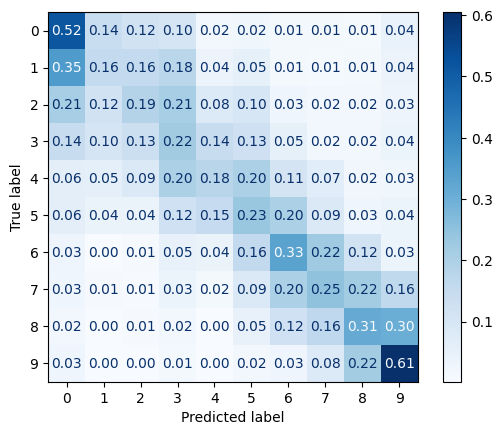

array([[0.51596517, 0.14223512, 0.11756168, 0.10449927, 0.01959361,
        0.02322206, 0.01161103, 0.01233672, 0.01015965, 0.04281567],
       [0.35347432, 0.15558912, 0.15558912, 0.17522659, 0.03625378,
        0.05135952, 0.01208459, 0.01057402, 0.01359517, 0.03625378],
       [0.21090047, 0.11611374, 0.18720379, 0.21090047, 0.08293839,
        0.09952607, 0.02606635, 0.01658768, 0.01895735, 0.03080569],
       [0.14311927, 0.10458716, 0.13211009, 0.22018349, 0.14495413,
        0.1266055 , 0.05137615, 0.02018349, 0.01834862, 0.03853211],
       [0.05993691, 0.05362776, 0.0851735 , 0.20189274, 0.17665615,
        0.20189274, 0.10725552, 0.06624606, 0.02208202, 0.02523659],
       [0.05960265, 0.0397351 , 0.0397351 , 0.12362031, 0.15231788,
        0.23399558, 0.200883  , 0.08609272, 0.02649007, 0.03752759],
       [0.03024194, 0.00403226, 0.00806452, 0.0483871 , 0.04032258,
        0.15927419, 0.33266129, 0.22379032, 0.11895161, 0.03427419],
       [0.02590674, 0.00777202, 0.0051813

In [16]:
plot_confusion_matrix(trainer,val_audience_dataset)

# Teste

In [17]:
test_audience['Rating'] = (test_audience['Rating']*2).astype(int)-1
test_audience_texts = test_audience["Review"].tolist()
test_audience_labels = test_audience["Rating"].tolist()
get_balanced_accuracy(model, tokenizer, test_audience_texts, test_audience_labels)

0.29

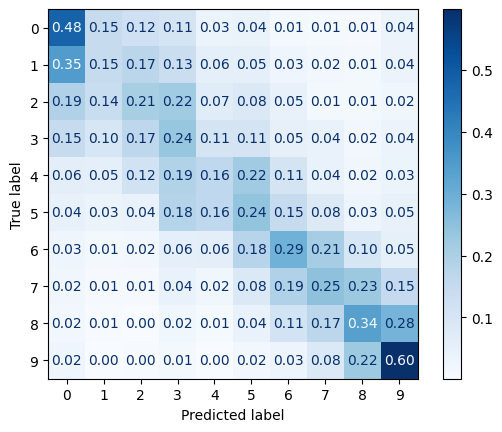

array([[0.47971095, 0.14674819, 0.12395775, 0.10783769, 0.03224013,
        0.04002223, 0.01389661, 0.00944969, 0.0077821 , 0.03835464],
       [0.34541336, 0.14722537, 0.16987542, 0.13363533, 0.05549264,
        0.05436014, 0.02604757, 0.01812005, 0.01472254, 0.03510759],
       [0.19037657, 0.14016736, 0.20502092, 0.21966527, 0.06903766,
        0.08368201, 0.0460251 , 0.0125523 , 0.01046025, 0.02301255],
       [0.14619883, 0.09649123, 0.16666667, 0.23538012, 0.10526316,
        0.10818713, 0.0497076 , 0.04093567, 0.01608187, 0.03508772],
       [0.05912596, 0.05398458, 0.11568123, 0.18766067, 0.16195373,
        0.218509  , 0.10796915, 0.04113111, 0.02056555, 0.03341902],
       [0.04460967, 0.03159851, 0.04275093, 0.1802974 , 0.1598513 ,
        0.23977695, 0.14684015, 0.07806691, 0.02973978, 0.0464684 ],
       [0.02672956, 0.01257862, 0.01886792, 0.05503145, 0.06132075,
        0.17610063, 0.29245283, 0.21069182, 0.09591195, 0.05031447],
       [0.02087683, 0.00626305, 0.0073068

In [18]:
test_encodings = tokenizer(list(test_audience['Review']), truncation=True, padding=True, max_length=128)
test_audience_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(test_audience['Rating'])
})
plot_confusion_matrix(trainer,test_audience_dataset)

In [19]:
mae(y_true=test_audience_labels, trainer=trainer, dataset=test_audience_dataset)

1.2498283098054177